In [179]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from pyargus import directionEstimation as de
import pandas as pd
from sklearn import preprocessing

In [180]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [181]:
df = pd.read_pickle("raw_IQ.pkl")

In [182]:
df.sort_values(['point', 'anchor', 'room', 'channel'], inplace=True)
# df.reset_index(inplace=True)
df = df.sort_values(['point', 'anchor', 'channel', 'room'])
df['mask'] = df['reference_power'] + df['relative_power']
df = df.sort_values(['point', 'anchor', 'channel', 'room', 'mask'])
# select to use either Vertical or Horizontal polarity based on reference and relative power
df = df.drop_duplicates(subset=['point', 'anchor', 'channel','room'], keep='first')

In [183]:
cols2 = ['pdda_input_imag1','pdda_input_imag2','pdda_input_imag3','pdda_input_imag4','pdda_input_imag5']
cols1 = ['pdda_input_real1','pdda_input_real2','pdda_input_real3','pdda_input_real4','pdda_input_real5']

def unpack(row):
    a,b,c,d,e = row
    # print(a)
    return a,b,c,d,e
    
df[cols1] = df.apply(lambda row: unpack(row['pdda_input_real']), axis=1, result_type='expand')
df[cols2] = df.apply(lambda row: unpack(row['pdda_input_imag']), axis=1, result_type='expand')


In [211]:

min_max_scaler = StandardScaler()
df[cols2] = min_max_scaler.fit_transform(df[cols2])
df[cols1] = min_max_scaler.fit_transform(df[cols1])
# df = pd.DataFrame(x_scaled)

In [212]:
cols3 = ['element1','element2','element3','element4','element5']
def complexify(reals,imags):
    complexs = []
    for i in range(len(reals)):
        complexs.append(reals[i] + 1j*imags[i])
    a,b,c,d,e = complexs
    return a,b,c,d,e

df[cols3] = df.apply(lambda row: complexify(row[cols1], row[cols2]), axis=1, result_type='expand')

In [213]:
mid_concrete = df[df['room'] == 'testbench_01_furniture_mid']
rest = df[df['room'] != 'testbench_01_furniture_mid']

In [214]:
mid_concrete.shape

(29364, 40)

In [215]:
rest.shape

(88092, 40)

In [216]:
mid_concrete.head()

,anchor,point,x_tag,y_tag,z_tag,los,relative_power,pdda_input_real,pdda_input_imag,pdda_phi,pdda_theta,pdda_out_az,pdda_out_el,true_phi,true_theta,x_anchor,y_anchor,z_anchor,az_anchor,el_anchor,reference_power,polarity,channel,room,mask,pdda_input_real1,pdda_input_real2,pdda_input_real3,pdda_input_real4,pdda_input_real5,pdda_input_imag1,pdda_input_imag2,pdda_input_imag3,pdda_input_imag4,pdda_input_imag5,element1,element2,element3,element4,element5
1,1,2,44.1,43.3,1.5,0,-27.5,"[0.0007300000000000001, 0.0036400000000000004,...","[-0.04662, -0.03962, -0.03127, -0.02306, -0.03...",-10.9,1.9,"[0.01467, 0.014730000000000002, 0.014900000000...","[0.008270000000000001, 0.00826, 0.00825, 0.008...",45.0,-4.1,57.9,43.3,2.5,135,0,-32.3,V,37,testbench_01_furniture_mid,-59.8,0.008162,0.036275,0.047471,0.196415,0.400671,-0.461858,-0.385809,-0.292861,-0.226018,-0.377623,0.008162-0.461858j,0.036275-0.385809j,0.047471-0.292861j,0.196415-0.226018j,0.400671-0.377623j
1,1,2,44.1,43.3,1.5,0,-25.8,"[-0.07509, -0.056440000000000004, -0.03867, -0...","[0.005430000000000001, 0.01297, 0.023080000000...",49.0,-6.2,"[0.019790000000000002, 0.01982, 0.01989, 0.020...","[0.02228, 0.022310000000000003, 0.022420000000...",45.0,-4.1,57.9,43.3,2.5,135,0,-30.7,H,38,testbench_01_furniture_mid,-56.5,-0.732025,-0.548142,-0.357205,-0.265159,0.038491,0.053305,0.123918,0.215746,0.337690,-0.115646,-0.732025+0.053305j,-0.548142+0.123918j,-0.357205+0.215746j,-0.265159+0.337690j,0.038491-0.115646j
1,1,2,44.1,43.3,1.5,0,-25.0,"[0.051410000000000004, 0.049440000000000005, 0...","[-0.013720000000000001, -0.02679, -0.037540000...",5.0,-5.4,"[0.00197, 0.0019600000000000004, 0.00192000000...","[0.016130000000000002, 0.016190000000000003, 0...",45.0,-4.1,57.9,43.3,2.5,135,0,-31.8,V,39,testbench_01_furniture_mid,-56.8,0.502922,0.481787,0.457832,0.505468,0.387385,-0.136232,-0.261455,-0.351535,-0.288964,-0.280887,0.502922-0.136232j,0.481787-0.261455j,0.457832-0.351535j,0.505468-0.288964j,0.387385-0.280887j
2451,2,2,44.1,43.3,1.5,0,-27.4,"[0.01793, 0.019440000000000002, 0.020900000000...","[-0.009290000000000001, -0.009500000000000001,...",9.7,1.4,"[2.63353, 2.63334, 2.63276, 2.63179, 2.63043, ...","[0.0011300000000000001, 0.0011200000000000001,...",-19.1,-3.7,57.9,50.0,2.5,225,0,-32.3,V,37,testbench_01_furniture_mid,-59.7,0.176076,0.189967,0.197863,-0.144846,0.002004,-0.092386,-0.093872,-0.078001,-0.197011,-0.813416,0.176076-0.092386j,0.189967-0.093872j,0.197863-0.078001j,-0.144846-0.197011j,0.002004-0.813416j
2451,2,2,44.1,43.3,1.5,0,-27.2,"[-0.00888, -0.011090000000000001, -0.014650000...","[0.006620000000000001, 0.009850000000000001, 0...",-55.7,-1.0,"[13.05508, 13.05633, 13.06007, 13.06628, 13.07...","[0.04224000000000001, 0.042260000000000006, 0....",-19.1,-3.7,57.9,50.0,2.5,225,0,-32.9,V,38,testbench_01_furniture_mid,-60.1,-0.085654,-0.107008,-0.133389,0.127497,0.848726,0.065083,0.093677,0.120482,-0.233657,0.129469,-0.085654+0.065083j,-0.107008+0.093677j,-0.133389+0.120482j,0.127497-0.233657j,0.848726+0.129469j


### use rest for training and mid concrete for testing

In [77]:
def create_cnn_data(df, anchor):
    df = df.sort_values(['point', 'room', 'anchor', 'channel'])
    df.reset_index(inplace=True)
    inputs = ['pdda_input_real_1', 'power', 'pdda_input_real_2', 'pdda_input_imag_2','pdda_input_real_3', 'pdda_input_imag_3', 
                'pdda_input_real_4', 'pdda_input_imag_4', 'pdda_input_real_5','pdda_input_imag_5']
    target = ['true_phi']
    anchor_df = df.loc[df['anchor'] == anchor]
    grouped = df.groupby('channel', sort=False)
    channels_df = []
    for group, tdf in grouped:
        # print('group of :', group)
        # print(tdf.shape)
        channels_df.append(tdf)
    assert channels_df[1].shape == channels_df[0].shape == channels_df[2].shape
    # check if the data is correctly split
    count =0
    i = 0
    for index, row in channels_df[0].iterrows():
        idx = row['index']
        # print(idx)
        count += 1
        # print(row[index])
        # print(channels_df[1].iloc[index]['index'])
        assert row['index'] == channels_df[1].iloc[i]['index'] == channels_df[2].iloc[i]['index']
        i += 1
    ch_36 = channels_df[0][inputs].values
    ch_37 = channels_df[1][inputs].values
    ch_38 = channels_df[2][inputs].values
    # print(ch_36.shape[0]*5,5)
    ch36_corr = []
    ch37_corr = []
    ch38_corr = []
    print(ch_36.shape[0])
    for i in range(ch_36.shape[0]):
        ch36_corr.append(np.cov(ch_36[i].reshape(5,2)))
        ch37_corr.append(np.cov(ch_37[i].reshape(5,2)))
        ch38_corr.append(np.cov(ch_38[i].reshape(5,2)))
    ch36_corr = np.asarray(ch36_corr)
    ch37_corr = np.asarray(ch37_corr)
    ch38_corr = np.asarray(ch38_corr)
    print(ch36_corr.shape)   
    # inputs = np.stack([ch_36,ch_37,ch_38],axis=1)
    inputs = np.stack([ch36_corr,ch37_corr,ch38_corr],axis=1)
    assert (channels_df[0]['true_phi'].values ==  channels_df[1]['true_phi'].values).all()
    outputs = channels_df[0]['true_phi'].values
    return (inputs, outputs)

In [78]:
df.head()

,anchor,point,x_tag,y_tag,z_tag,los,relative_power,pdda_input_real,pdda_input_imag,pdda_phi,pdda_theta,pdda_out_az,pdda_out_el,true_phi,true_theta,x_anchor,y_anchor,z_anchor,az_anchor,el_anchor,reference_power,polarity,channel,room,mask
1,1,2,44.1,43.3,1.5,1,-23.8,"[0.035570000000000004, 0.022350000000000002, 0...","[-0.02636, -0.02272, -0.02244, -0.00117, -0.04...",-1.2,-7.1,"[0.03465, 0.03472, 0.03492, 0.03526, 0.0357500...","[0.025810000000000003, 0.02585, 0.02596, 0.026...",45.0,-4.1,57.9,43.3,2.5,135,0,-32.8,V,37,testbench_01,-56.6
1,1,2,44.1,43.3,1.5,0,-38.4,"[-0.003, 0.00234, 0.00591, 0.00097, 0.02076]","[-0.0025800000000000003, 0.00218, 0.0072400000...",90.5,47.5,"[1.1703700000000001, 1.17058, 1.17121, 1.17225...","[0.8172200000000001, 0.8176000000000001, 0.818...",45.0,-4.1,57.9,43.3,2.5,135,0,-32.8,V,37,testbench_01_furniture_high,-71.2
1,1,2,44.1,43.3,1.5,1,-28.0,"[-0.00538, -0.00657, -0.007790000000000001, 0....","[-0.02015, -0.01948, -0.02015, -0.00536, -0.04...",-8.0,-1.5,"[0.13232000000000002, 0.13256, 0.13328, 0.1344...","[0.0005200000000000001, 0.0005300000000000001,...",45.0,-4.1,57.9,43.3,2.5,135,0,-32.7,V,37,testbench_01_furniture_low,-60.7
1,1,2,44.1,43.3,1.5,0,-27.5,"[0.0007300000000000001, 0.0036400000000000004,...","[-0.04662, -0.03962, -0.03127, -0.02306, -0.03...",-10.9,1.9,"[0.01467, 0.014730000000000002, 0.014900000000...","[0.008270000000000001, 0.00826, 0.00825, 0.008...",45.0,-4.1,57.9,43.3,2.5,135,0,-32.3,V,37,testbench_01_furniture_mid,-59.8
1,1,2,44.1,43.3,1.5,1,-22.0,"[-0.10138000000000001, -0.07936, -0.0582200000...","[-0.00429, 0.007730000000000001, 0.02262, 0.03...",7.1,-5.5,"[0.0047, 0.004690000000000001, 0.00468, 0.0046...","[0.019600000000000003, 0.01963, 0.01973, 0.019...",45.0,-4.1,57.9,43.3,2.5,135,0,-32.7,V,38,testbench_01,-54.7


In [217]:
def create_raw_data(df, anchor):
    df = df.sort_values(['point', 'room', 'anchor', 'channel'])
    df.reset_index(inplace=True)
    inputs = ['element1', 'element2', 'element3', 'element4','element5']
    target = ['true_phi']
    anchor_df = df.loc[df['anchor'] == anchor]
    grouped = df.groupby('channel', sort=False)
    channels_df = []
    for group, tdf in grouped:
        # print('group of :', group)
        # print(tdf.shape)
        channels_df.append(tdf)
    assert channels_df[1].shape == channels_df[0].shape == channels_df[2].shape
    # check if the data is correctly split
    count =0
    i = 0
    for index, row in channels_df[0].iterrows():
        idx = row['index']
        # print(idx)
        count += 1
        # print(row[index])
        # print(channels_df[1].iloc[index]['index'])
        assert row['index'] == channels_df[1].iloc[i]['index'] == channels_df[2].iloc[i]['index']
        i += 1
    ch_36 = channels_df[0][inputs].values
    ch_37 = channels_df[1][inputs].values
    ch_38 = channels_df[2][inputs].values
    # tmp = []
    # print(ch_36.shape[0])
    inputs = []
    for i in range(ch_36.shape[0]):
        X = []
        X.append(ch_36[i])
        X.append(ch_37[i])
        X.append(ch_38[i])
        R = de.corr_matrix_estimate(np.asarray(X).T)
        real = R.real
        img = R.imag
        data_arr = np.append(real.reshape(3, 3, 1), img.reshape(3, 3, 1), axis=2)
        data_lst = list(data_arr.ravel())
        inputs.append(data_lst)
    assert (channels_df[0]['true_phi'].values ==  channels_df[1]['true_phi'].values).all()
    outputs = channels_df[0]['true_phi'].values
    return (np.asarray(inputs), outputs)

In [218]:
inputs, outputs = create_raw_data(df,1)

In [9]:
    features = ['pdda_input_real_1', 'power', 'pdda_input_real_2', 'pdda_input_imag_2','pdda_input_real_3', 'pdda_input_imag_3', 
                'pdda_input_real_4', 'pdda_input_imag_4', 'pdda_input_real_5','pdda_input_imag_5']

In [85]:
x =df[features].values[0]

In [86]:
x = x.reshape(10,1)

In [91]:
y = np.concatenate((x,x),axis=1)

In [93]:
y

array([[ 0.04427273,  0.04427273],
       [-0.11066281, -0.11066281],
       [ 0.03148414,  0.03148414],
       [-0.00494671, -0.00494671],
       [ 0.02086481,  0.02086481],
       [-0.01246791, -0.01246791],
       [ 0.06138766,  0.06138766],
       [ 0.04403653,  0.04403653],
       [ 0.10470526,  0.10470526],
       [ 0.02641372,  0.02641372]])

In [95]:
np.cov(y)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [75]:
y.reshape(10,2)

array([[ 0.04427273, -0.11066281],
       [ 0.03148414, -0.00494671],
       [ 0.02086481, -0.01246791],
       [ 0.06138766,  0.04403653],
       [ 0.10470526,  0.02641372],
       [ 0.04427273, -0.11066281],
       [ 0.03148414, -0.00494671],
       [ 0.02086481, -0.01246791],
       [ 0.06138766,  0.04403653],
       [ 0.10470526,  0.02641372]])

In [96]:
# np.cov(x,x)

In [219]:
X_test, y_test = create_raw_data(mid_concrete,1.0)
X_train, y_train = create_raw_data(rest, 1.0)

In [220]:
X_train.shape

(29364, 18)

In [221]:
X_test.shape

(9788, 18)

In [12]:
X_test, y_test = create_cnn_data(mid_concrete,1.0)
X_train, y_train = create_cnn_data(rest, 1.0)

9788
(9788, 5, 5)
29364
(29364, 5, 5)


In [13]:
y_test.shape

(9788,)

In [14]:
# X, y = create_cnn_data(mid_concrete, 1.0)

In [15]:
assert X_test.shape[0]*X_test.shape[1] == mid_concrete.shape[0]
assert X_train.shape[0]*X_train.shape[1] == rest.shape[0]

In [103]:
X_train.shape[0]

29364

In [226]:
train_x = torch.Tensor(X_train.astype(np.float32)) # transform to torch tensor
train_x.shape

torch.Size([29364, 3, 5, 5])

In [222]:
X_train = X_train.reshape(29364,3,3,2)

In [223]:
X_test = X_test.reshape(9788,3,3,2)

In [232]:
# train_x = torch.Tensor(X_train.reshape(X_train.shape[0],X_train.shape[1],2,5).astype(np.float32)) # transform to torch tensor
# train_y = torch.Tensor(y_train.astype(np.float32))
train_x = torch.Tensor(X_train.astype(np.float32))
train_y = torch.Tensor(y_train.astype(np.float32))
train_dataset = TensorDataset(train_x,train_y)

# test_x = torch.Tensor(X_test.reshape(X_test.shape[0],X_test.shape[1],2,5).astype(np.float32)) # transform to torch tensor
test_x = torch.Tensor(X_test.astype(np.float32))
test_y = torch.Tensor(y_test.astype(np.float32))
test_dataset = TensorDataset(test_x,test_y)
BATCH_SIZE = 512
train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_x.shape[0],shuffle=True)

In [52]:
train_x.shape

torch.Size([29364, 3, 5, 5])

In [53]:
train_y.shape

torch.Size([29364])

In [19]:
test_x.shape

torch.Size([9788, 3, 5, 5])

In [259]:
X = torch.Tensor(X.reshape(X.shape[0],X.shape[1],2,5).astype(np.float32)) # transform to torch tensor
y = torch.Tensor(y.astype(np.float32))
full_dataset = TensorDataset(X,y)

NameError: name 'X' is not defined

In [260]:
train_size = int(0.66 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

NameError: name 'full_dataset' is not defined

In [261]:
train_size

NameError: name 'train_size' is not defined

In [194]:
test_size

3328

In [195]:
BATCH_SIZE = 128
train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_x.shape[0],shuffle=True)

In [34]:
# CNN1 512, kernel=3 × 3 [B, 2, 2, 512]
# BN n/a [B, 2, 2, 512]
# Activation Activation=‘ReLU’ [B, 2, 2, 512]
# MaxPool pool size=2 × 2 [B, 1, 1, 512]
# FC2 1024 [B, 1024]
# Dropout2 rate = 0.2 [B, 1024]
# FC3 1024 [B, 1024]
# Dropout3 rate = 0.2 [B, 1024]
# FC4 512 [B, 512]
# Dropout4 rate = 0.2 [B, 512]

# in_channels (int) – Number of channels in the input image

# out_channels (int) – Number of channels produced by the convolution

# kernel_size (int or tuple) – Size of the convolving kernel

In [297]:
class DeepAoA(nn.Module):
    input_channels = 3
    channels_conv1 = 512
    kernel_conv1 = [3, 2]
    
    def __init__(self):
        super(DeepAoA, self).__init__()
        self.conv1 = nn.Conv2d(self.input_channels, self.channels_conv1, self.kernel_conv1)
        self.b1 = nn.BatchNorm2d(self.channels_conv1)
        self.fc1 = nn.Linear(512, 1024) 
        self.fc2 = nn.Linear(1024, 1024) 
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 1)
        # self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        out = self.conv1(x)
        out = self.b1(out)
        out = F.relu(out)
        out = F.max_pool2d(out, (1,1))
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = F.relu(out)
        # out = self.dropout(out)
        out = self.fc2(out)
        out = F.relu(out)
        # out = self.dropout(out)
        out = self.fc3(out)
        out = F.relu(out)
        # out = self.dropout(out)
        out = self.fc4(out)
        return out

In [298]:
aoa = DeepAoA()

In [299]:
aoa

DeepAoA(
  (conv1): Conv2d(3, 512, kernel_size=(3, 2), stride=(1, 1))
  (b1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=1, bias=True)
)

In [300]:
criterion = nn.MSELoss()
optimizer = optim.Adam(aoa.parameters(),lr=0.001)

In [301]:
def train(epoch):
    print('Epoch : %d'%epoch)

    aoa.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = aoa(inputs)
        
        loss = criterion(outputs[:,0], labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 500 == 499:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #     running_loss = 0.0
    train_loss=running_loss/len(train_dataloader)
    print(f'[{epoch + 1}] loss: {running_loss / 2000:.3f}')
    print(train_loss)
    # print(len(train_dataloader))
    train_accu.append(train_loss)
    return

In [302]:
def test(epoch):
    aoa.eval()
    running_loss=0
    with torch.no_grad():
        for data in test_dataloader: 
            inputs, labels = data 
            predicted_outputs = aoa(inputs) 
            loss = criterion(predicted_outputs[:,0], labels)
            running_loss += loss
        test_loss=running_loss/len(test_dataloader)
        test_accu.append(test_loss)
    return

In [303]:
test_accu = []
train_accu = []
for i in range(10):
    train(i)
    test(i)

Epoch : 0
[1] loss: 22.034
759.7821318527748
Epoch : 1
[2] loss: 21.980
757.9450673070447
Epoch : 2
[3] loss: 21.959
757.2075290022225
Epoch : 3
[4] loss: 21.914
755.6712688577586
Epoch : 4
[5] loss: 21.857
753.7011308341191
Epoch : 5
[6] loss: 21.795
751.5492259058459
Epoch : 6
[7] loss: 21.658
746.8175585516568
Epoch : 7
[8] loss: 21.590
744.4706347235318
Epoch : 8
[9] loss: 21.502
741.4387838429418
Epoch : 9
[10] loss: 21.386
737.4361835348195


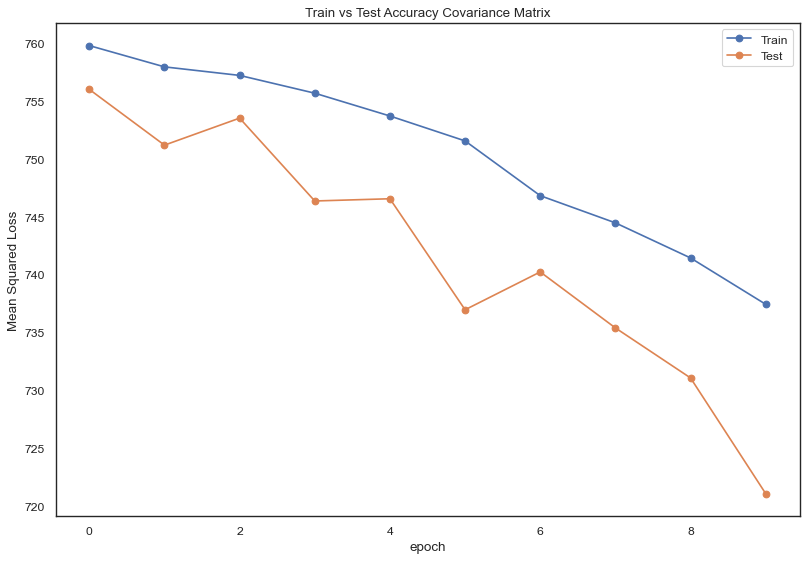

In [304]:
figure(figsize=(12, 8), dpi=80)
plt.plot(train_accu,'-o')
plt.plot(test_accu,'-o')

plt.xlabel('epoch')
plt.ylabel('Mean Squared Loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy Covariance Matrix')
# plt.savefig('train_test_m_cov.png')
plt.show()

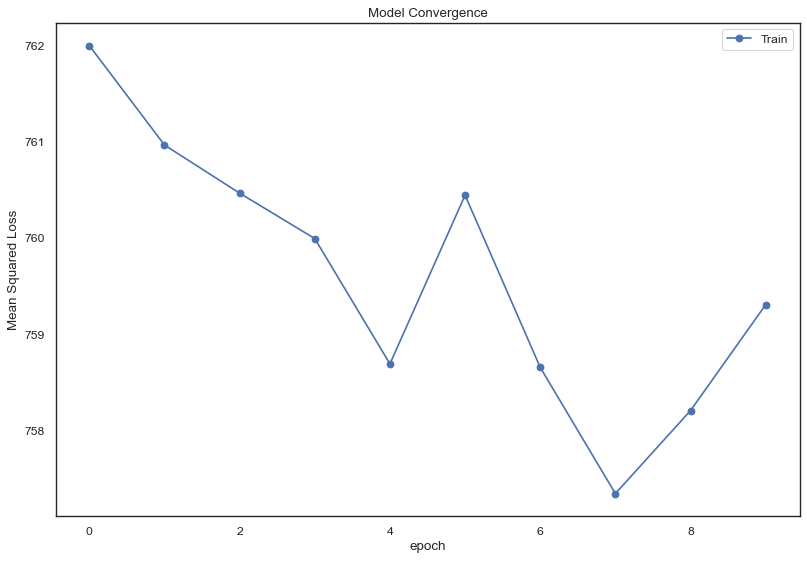

In [247]:
figure(figsize=(12, 8), dpi=80)
plt.plot(train_accu,'-o')
# plt.plot(test_accu,'-o')

plt.xlabel('epoch')
plt.ylabel('Mean Squared Loss')
plt.legend(['Train','Test'])
plt.title('Model Convergence')
# plt.savefig('model_conv_mid.png',bbox="tight")
plt.show()

In [147]:
results = {"mid_rest_mae": 11.87}

In [148]:
mae = nn.L1Loss()

In [149]:
aoa.eval()
preds = pd.DataFrame()
gt = pd.DataFrame()
with torch.no_grad(): 
    for data in test_dataloader: 
        inputs, outputs = data 
        predicted_outputs = aoa(inputs) 
        print(predicted_outputs.shape)
        print(outputs.shape)
        print(mae(predicted_outputs[:,0], outputs))
        preds['preds'] = predicted_outputs[:,0]
        preds['Model'] = 'DeepAoANet Covariance'
        print(outputs.shape)
        gt['true'] = outputs
        gt['Model'] = 'Ground Truth'
        

torch.Size([9788, 1])
torch.Size([9788])
tensor(23.9557)
torch.Size([9788])


/var/folders/l_/cjgh4zp97tx6xy5fhn4tzw9w0000gn/T/ipykernel_49758/2886205985.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('model_conv_mid_densities_cov.png',bbox='tight')


<Figure size 960x640 with 0 Axes>

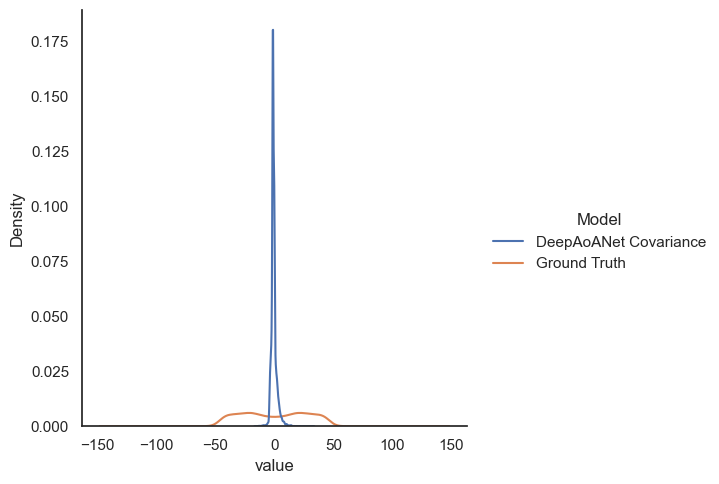

In [150]:
# recast into long format 
res = pd.DataFrame()
# sns.set(rc={'figure.figsize':(12,8.27)})
figure(figsize=(12, 8), dpi=80)
sns.set_theme(style='white')
res['value'] = pd.concat([preds['preds'], gt['true']],axis=0)
res['Model'] = pd.concat([preds['Model'], gt['Model']], axis=0)
sns.displot(x=res['value'], kind="kde", hue=res['Model'])
plt.savefig('model_conv_mid_densities_cov.png',bbox='tight')
plt.show()

In [151]:
res.head()

,value,Model
0,1.984799,DeepAoANet Covariance
1,3.714398,DeepAoANet Covariance
2,-1.415913,DeepAoANet Covariance
3,1.530011,DeepAoANet Covariance
4,-1.517265,DeepAoANet Covariance


In [25]:
from torchviz import make_dot

In [29]:
aoa.eval()
with torch.no_grad(): 
    for data in test_dataloader: 
        inputs, outputs = data 
        # predicted_outputs = aoa(inputs) 
        
        y = aoa(inputs) 
        break
make_dot(y.mean(), params=dict(aoa.named_parameters()))
    

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [88]:
predicted_outputs = aoa(inputs) 

In [89]:
predicted_outputs[:,0][:10]

tensor([ 29.6880, -34.9713, -33.8857,  66.4720,  35.4059, -20.4038, -37.5289,
         40.0270,  30.0361, -21.0583], grad_fn=<SliceBackward0>)

In [90]:
outputs[:10]

tensor([ 45.0000, -19.1000, -46.7000, 135.0000,  44.2000, -19.8000, -46.8000,
         90.0000,  43.3000, -20.5000])